# **Bolt Test Task**
## Supply Data Analysis
Author: Nadiia Danylyshyn

---
## Introduction
In the frame of this assignment supply/demand data will be analyzed.

The aim of this report is to provide answers to the following questions:
1. What is the supply to demand dynamic and whether they match?
2. Where are the hours of oversupply? Can we shift some of them to undersupply hours?

The following points will be investigated:
- 36 most undersupplied hours
- 24-hour curve of average supply and demand
- Visualization of supply lack during a weekly period
- Number of hours needed to have a high Coverage Ratio during most peak hours
- Guaranteed hourly earnings that can be offered to drivers during 36 weekly hours with the highest demand

### Data description

Data for the analysis is real hourly data of a city during a 5-weeks time frame from 2016-11-14 until 2016-12-18.

**Supply data variables:**
- Date
- Active drivers
- Online (h)
- Has booking (h)
- Waiting for booking (h)
- Busy (h)
- Hours per active driver
- Rides per online hour
- Finished Rides

**Demand data variables:**
- Date
- People saw 0 cars (unique)
- People saw +1 cars (unique)
- Coverage Ratio (unique)
---

### Data preprocessing

In [1]:
# Libraries import

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
# Supply data

supply = pd.read_csv('Hourly_DriverActivity_1.csv')
supply.head()

,Date,Active drivers,Online (h),Has booking (h),Waiting for booking (h),Busy (h),Hours per active driver,Rides per online hour,Finished Rides
0,2016-12-18 23,52,18,6,11,11,0.3,0.67,12.0
1,2016-12-18 22,59,20,11,9,12,0.3,1.40,28.0
2,2016-12-18 21,72,25,7,18,15,0.3,0.64,16.0
3,2016-12-18 20,86,29,7,23,15,0.3,0.52,15.0
4,2016-12-18 19,82,31,14,17,19,0.4,1.16,36.0


In [3]:
# Demand data

demand = pd.read_csv('Hourly_OverviewSearch_1.csv')
demand.head()

,Date,People saw 0 cars (unique),People saw +1 cars (unique),Coverage Ratio (unique)
0,2016-12-18 23,9,32,78
1,2016-12-18 22,29,64,69
2,2016-12-18 21,5,39,89
3,2016-12-18 20,13,48,79
4,2016-12-18 19,12,77,87


In [4]:
# Splitting Date column into date and hour
# Supply
supply_date = supply['Date'].str.split(' ', expand=True)
supply_2 = pd.concat([supply_date, supply], axis=1)
del supply_2['Date']
supply_2.columns = ['Date', 'Hour', 'Active drivers', 'Online (h)', 'Has booking (h)', 'Waiting for booking (h)', 
                    'Busy (h)', 'Hours per active driver', 'Rides per online hour', 'Finished Rides']
supply_2['Finished Rides'] = supply_2['Finished Rides'].fillna(0)
supply_2['Date'] = pd.to_datetime(supply_2['Date'])
supply_2['Day of week'] = supply_2['Date'].dt.dayofweek

# Demand
demand_date = demand['Date'].str.split(' ', expand=True)
total_users = demand['People saw 0 cars (unique)'] + demand['People saw +1 cars (unique)']
demand_2 = pd.concat([demand_date, demand, total_users], axis=1)
del demand_2['Date']
demand_2.columns = ['Date', 'Hour', 'People saw 0 cars (unique)', 'People saw +1 cars (unique)', 'Coverage Ratio (unique)', 
                    'Total users']
demand_2['Date'] = pd.to_datetime(demand_2['Date'])
demand_2['Day of week'] = demand_2['Date'].dt.dayofweek

### 36 hours in a week that are most undersupplied
The fundamental point of the assignment is the determination of what is considered under *demand* and *supply*. Based on available variables, I assume, that *demand* is all people who was looking for a car ("People saw 0 cars" + "People saw +1 cars") and *supply* is the number of active drivers. I agree that it may be not an optimal definition and alternative ways of defining demand and supply can be provided.

Based on assumed demand and supply definitions, the **undersupply** is formed when demand > supply

In [5]:
# Computation of undersupply scores

undersupply = demand_2['People saw 0 cars (unique)'] + demand_2['People saw +1 cars (unique)'] - supply_2['Active drivers']
undersupply = undersupply.to_frame()

hour_dayofweek = demand_2[['Hour', 'Day of week']]
undersupply_2 = pd.concat([hour_dayofweek, undersupply], axis=1)
undersupply_2.columns = ['Hour', 'Day of week', 'Undersupply']

undersupply_2 = undersupply_2.drop(undersupply_2[undersupply_2.Undersupply < 0].index)
#undersupply_2.head()

In [6]:
# Defining 36 most undersupplied hours

undersupply_3 = undersupply_2.groupby(['Hour', 'Day of week'])['Undersupply'].mean()
undersupply_3 = undersupply_3.to_frame()
undersupply_4 = undersupply_3.sort_values(by='Undersupply', ascending=False)
undersupply_5 = undersupply_4.head(36)
undersupply_5

,,Undersupply
Hour,Day of week,
19,4.0,107.000000
20,3.0,93.000000
18,4.0,92.000000
20,4.0,91.000000
19,3.0,83.000000
18,3.0,82.333333
02,5.0,70.500000
21,4.0,68.000000
03,5.0,65.666667


**Note:** "0" = Monday, "6" = "Sunday"

In [7]:
undersupply_5.sort_values(by='Hour', ascending=True)

Undersupply
Hour Day of week             
00   5.0            39.000000
01   4.0            31.000000
     5.0            54.000000
02   4.0            51.000000
     5.0            70.500000
03   5.0            65.666667
04   6.0            33.000000
     2.0            40.000000
     5.0            61.333333
08   0.0            27.333333
     1.0            53.000000
     3.0            27.000000
     4.0            28.750000
09   1.0            31.000000
     5.0            39.000000
     4.0            59.500000
11   4.0            29.000000
12   4.0            37.000000
13   4.0            48.000000
14   4.0            29.000000
15   4.0            32.666667
16   4.0            40.000000
17   2.0            48.500000
     4.0            34.000000
18   0.0            29.000000
     4.0            92.000000
     3.0            82.333333
     2.0            51.000000
     6.0            30.000000
19   4.0           107.000000
     3.0            83.000000
     5.0            39.000000
     2.0            47.500000
20   4.0            91.000000
     3.0            93.000000
21   4.0            68.000000

The most undersupplied hours here are **4, 8, 9, 18, 19**

### 24-hour graph

In order to build a 24-hour graph the average values of demand and supply for each hour is calculated

In [8]:
data_supplygraph = {'x': np.arange(24),
        'y': supply_2.groupby(['Hour'])['Active drivers'].mean()}
dem = demand_2['People saw 0 cars (unique)'] + demand_2['People saw +1 cars (unique)']
dem = dem.to_frame()
hour = demand_2['Hour']
dem = pd.concat([hour, dem], axis=1)
dem.columns = ['Hour', 'Demand']
data_demandgraph = {'x': np.arange(24),
        'y': dem.groupby(['Hour'])['Demand'].mean()}

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  """
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


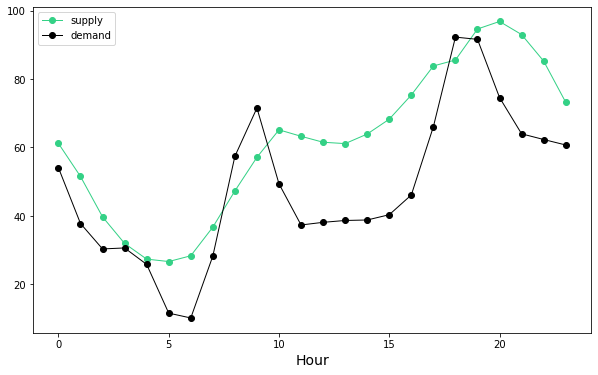

In [9]:
# Plotting graph

plt.figure(figsize=(10,6))
plt.xlabel('Hour', fontsize=14)
plt.plot( 'x', 'y', data=data_supplygraph, marker='o',color='#34D186', linewidth=1, label="supply")
plt.plot( 'x', 'y', data=data_demandgraph, marker='o', color='black', linewidth=1, label="demand")
plt.legend()

As it can be seen from the received graph, there are hours that are oversupplied and undersupplied. Hours **9** and **18** forms peak points

### Supply during weekly period

The visualization of hours where there is a lack supply during a weekly period was done using **Microsoft Power BI** based on *undersupply_4* variable

![Hours of undersupply](Bolt.png)

###  Number of hours needed to ensure a high Coverage Ratio during most peak hours

First of all, it is needed to define the list of hours that should be considered as "most peak hours". Additionally, coverage ratio and online hours graphs may provide some insights.

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


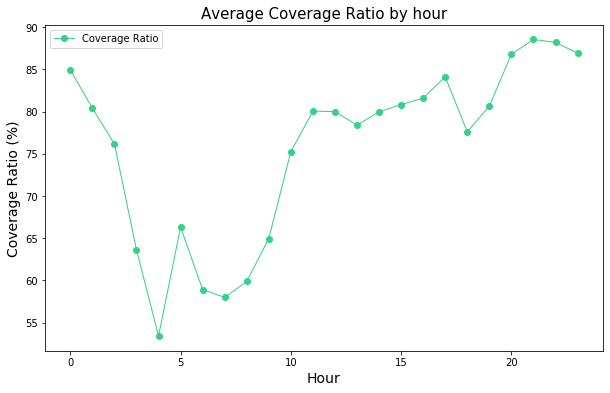

In [10]:
# Coverage Ratio graph

coverageratio_graph = {'x': np.arange(24),
        'y': demand_2.groupby(['Hour'])['Coverage Ratio (unique)'].mean()}
plt.figure(figsize=(10,6))
plt.plot( 'x', 'y', data=coverageratio_graph, marker='o',color='#34D186', linewidth=1, label="Coverage Ratio")
plt.title('Average Coverage Ratio by hour', fontsize=15)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Coverage Ratio (%)', fontsize=14)
plt.legend()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  """


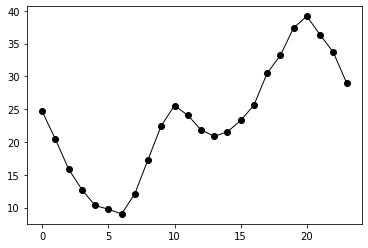

In [11]:
# Graph of online hours

onlinehours_graph = {'x': np.arange(24),
        'y': supply_2.groupby(['Hour'])['Online (h)'].mean()}
plt.plot( 'x', 'y', data=onlinehours_graph, marker='o',color='black', linewidth=1, label="Online hours")

In general, Coverage Ratio and Online hours graphs are following the same trends

For the estimation of the number of hours needed to ensure that there is a high Coverage Ratio, firstly I would like to check the dependencies between online hours and coverage ratio

In [12]:
# Investigation of relationship between Online hours and Coverage Ratio

y = coverageratio_graph['y']
x = onlinehours_graph['y']
y = y.array
x = x.array
y = y.to_numpy()
x = x.to_numpy()
y = y.reshape(-1,1)
x = x.reshape(-1,1)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
model = est.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     42.00
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.61e-06
Time:                        00:04:35   Log-Likelihood:                -77.421
No. Observations:                  24   AIC:                             158.8
Df Residuals:                      22   BIC:                             161.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.2788      3.688     14.446      0.0

As it can be seen from the linear regression, where coverage ratio is dependent variable and online hours is independent variable, in general a 1 hour increase of online hours, leads to 0.96 percentage points increase of coverage ratio. Assume that 1 hour increase of online hours is equal to 1 percentage point of coverage ratio.

In [13]:
# Coverage Ratio and Online hours

cr_oh = pd.concat([onlinehours_graph['y'], coverageratio_graph['y']], axis=1)
cr_oh

,Online (h),Coverage Ratio (unique)
Hour,,
00,24.657143,84.942857
01,20.428571,80.400000
02,15.857143,76.171429
03,12.742857,63.628571
04,10.314286,53.428571
05,9.742857,66.323529
06,9.028571,58.914286
07,12.085714,58.000000
08,17.314286,59.885714


From the 24-hour graph, the most peak hours can be defined as *9, 17, 18, 19, 20*. Let's assume that good coverage ratio is *80+ %*

In [14]:
# Online hours needed to have 80+ % coverage ratio

peak = [9, 17, 18, 19, 20]
sumofhours = 0
for n in peak:
    if y[n] < 80:
        sumofhours = sumofhours + (80-y[n])

print(sumofhours)

[17.42857143]


So, under the assumptions made, around **17** online hours daily would be needed to assure 80+ % coverage ratio during the most peak hours

### Levels of guaranteed hourly earnings 

In [15]:
# 36 weekly hours with with highest demand

finished_rides = supply_2['Finished Rides']
RPH = supply_2['Rides per online hour']
online = supply_2['Online (h)']
dayofweek = demand_2['Day of week']
zero_cars = demand_2['People saw 0 cars (unique)']
one_car = demand_2['People saw +1 cars (unique)']
highest_demand = pd.concat([dayofweek, dem, finished_rides, RPH, online, zero_cars, one_car], axis=1)
highest_demand = highest_demand.groupby(['Hour', 'Day of week']).mean()
highest_demand = highest_demand.sort_values(by = 'Demand', ascending=False)
highest_demand = highest_demand.head(36)
highest_demand

Demand  Finished Rides  Rides per online hour  Online (h)  \
Hour Day of week                                                              
18   3.0           128.4            31.0                  0.914        36.2   
19   4.0           119.4            24.8                  0.650        41.0   
     3.0           117.4            31.2                  0.854        38.8   
18   4.0           116.2            30.0                  0.744        43.4   
20   4.0           113.2            32.8                  0.822        43.0   
18   2.0           110.4            28.4                  0.874        33.8   
     1.0           104.2            29.6                  0.840        37.4   
09   4.0           102.2            22.0                  0.930        26.6   
19   2.0           100.8            24.6                  0.680        40.2   
21   4.0            98.2            27.8                  0.664        45.0   
19   1.0            96.8            26.2                  0.684        39.2   
20   3.0            93.8            29.2                  0.794        37.6   
09   1.0            92.8            16.8                  0.666        27.8   
     2.0            88.8            19.4                  0.712        30.2   
17   2.0            87.2            26.0                  0.818        32.4   
09   0.0            84.0            16.8                  0.684        26.8   
17   3.0            83.6            26.6                  0.898        31.0   
     4.0            83.6            24.8                  0.678        38.0   
09   3.0            80.6            23.6                  0.806        29.8   
03   5.0            80.0            20.4                  1.074        19.0   
08   1.0            79.2            25.6                  1.018        26.6   
23   3.0            79.0            29.8                  1.076        27.6   
00   5.0            79.0            27.0                  0.824        32.2   
21   3.0            77.8            32.8                  0.934        35.2   
18   0.0            76.6            23.0                  0.616        36.8   
22   4.0            75.8            28.8                  0.682        41.0   
20   5.0            74.2            25.2                  0.670        42.0   
01   5.0            74.0            29.6                  1.008        29.2   
19   0.0            73.4            18.2                  0.524        36.8   
02   5.0            73.0            23.8                  0.956        24.4   
08   0.0            71.8            23.6                  1.050        23.4   
     2.0            71.6            21.4                  0.824        26.0   
23   4.0            71.6            27.2                  0.694        37.6   
08   4.0            71.4            21.2                  1.060        22.6   
19   5.0            70.8            23.8                  0.674        39.0   
00   6.0            70.6            26.8                  0.788        34.8   

                  People saw 0 cars (unique)  People saw +1 cars (unique)  
Hour Day of week                                                           
18   3.0                                52.2                         76.2  
19   4.0                                34.6                         84.8  
     3.0                                37.4                         80.0  
18   4.0                                30.4                         85.8  
20   4.0                                29.8                         83.4  
18   2.0                                38.2                         72.2  
     1.0                                34.8                         69.4  
09   4.0                                45.6                         56.6  
19   2.0                                29.0                         71.8  
21   4.0                                22.4                         75.8  
19   1.0                                19.6                         77.2  
20   3.0                   

In [16]:
# Guaranteed hourly earnings of drivers under current demand and supply levels

avg_priceofride = 10
driver_earning_per_ride = avg_priceofride * 0.8
bolt_earning_per_ride = avg_priceofride * 0.2
drivers_earnings_per_hour = highest_demand['Finished Rides'] * driver_earning_per_ride
guarant_driver_earning = drivers_earnings_per_hour / highest_demand['Online (h)']
guarant_driver_earning

Hour  Day of week
18    3.0            6.850829
19    4.0            4.839024
      3.0            6.432990
18    4.0            5.529954
20    4.0            6.102326
18    2.0            6.721893
      1.0            6.331551
09    4.0            6.616541
19    2.0            4.895522
21    4.0            4.942222
19    1.0            5.346939
20    3.0            6.212766
09    1.0            4.834532
      2.0            5.139073
17    2.0            6.419753
09    0.0            5.014925
17    3.0            6.864516
      4.0            5.221053
09    3.0            6.335570
03    5.0            8.589474
08    1.0            7.699248
23    3.0            8.637681
00    5.0            6.708075
21    3.0            7.454545
18    0.0            5.000000
22    4.0            5.619512
20    5.0            4.800000
01    5.0            8.109589
19    0.0            3.956522
02    5.0            7.803279
08    0.0            8.068376
      2.0            6.584615
23    4.0            5

Found levels are average and some fluctuations are possible. Guaranteed (safe) range can be defined as **4.5-7.5 euros** per online hour

Extra online hours needed to capture "missed demand" are calclated besed on the ratio: 

*current online hours/people saw +1 cars = extra online hours/people saw 0 cars*

In [17]:
# Extra online hours needed to capture "missed demand" during 36 weekly hours with the highest demand 

hours_missed_demand = highest_demand['Online (h)'] * highest_demand['People saw 0 cars (unique)'] / highest_demand['People saw +1 cars (unique)']
hours_missed_demand = hours_missed_demand.sum(axis = 0)
hours_missed_demand

478.7551841437874

As it can be seen, during 36 weekly hours with the highest demand, around **479** extra online hours are needed to cover "missed demand"

## Conclusions

Moving back to the questions that were stated at the beginning, the dynamics of supply-demand can be analyzed based on a daily or weekly average. Generally, there is a slight **mismatch** between demand and supply values.

Analyzing daily supply-demand, in most of the hours there is oversupply, which can be shifted to most peak hours as 8, 9, 18

Speaking about weekly supply-demand, Thursday and Friday during 18, 19, 20 hours are mostly undersupplied.
